<a href="https://colab.research.google.com/github/triender/CS231/blob/main/LBP_with_enhance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO
# MSSV: 22521521
# Tên: Nguyễn Minh Trí
# Phương pháp trích xuất đặc trưng: Local Binary Pattern (LBP)
# Mô hình máy học: Support Vector Machine (SVM)


#Library

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras

#Statistics

In [ ]:
# Function to count number of images in each directory
def count_images(data_dir):
    counts = {}
    for split in ['train', 'test', 'val']:
        split_counts = {}
        for label in ['Car', 'Motorbike']:
            label_dir = os.path.join(data_dir, split, label)
            count = len([file for file in os.listdir(label_dir)])
            split_counts[label] = count
        counts[split] = split_counts
    return counts

# Count number of images
data_dir = '/gdrive/MyDrive/Data/Data_Split'
counts = count_images(data_dir)

# Display counts
split_counts = {}
print("-----Number of images-----")
for split, split_counts in counts.items():
    print(f"\n{split.capitalize()} set")
    for label, count in split_counts.items():
        print(f"{label}: {count}")

# Total number of car and motorbike images
total_car = counts['train']['Car'] + counts['test']['Car'] + counts['val']['Car']
total_motorbike = counts['train']['Motorbike'] + counts['test']['Motorbike'] + counts['val']['Motorbike']
print(f"\nTotal Car images: {total_car}")
print(f"Total Motorbike images: {total_motorbike}")

-----Number of images-----

Train set
Car: 1473
Motorbike: 1462

Test set
Car: 246
Motorbike: 245

Val set
Car: 245
Motorbike: 243

Total Car images: 1964
Total Motorbike images: 1950


#Load Data

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load data from directory with data enhancement
def load_data(data_dir, data_augmentation=False, target_size=(224, 224)):
    X, y = [], []
    for label in ['Car', 'Motorbike']:
        label_dir = os.path.join(data_dir, label)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            # Read the image
            image = cv2.imread(image_path)
            # Resize the image to target size
            image = cv2.resize(image, target_size)
            # Apply data augmentation if specified
            if data_augmentation:
                image = augment_image(image)
            # Append the image and corresponding label to X and y lists
            X.append(image)
            y.append(1 if label == 'Car' else 0)
    return np.array(X), np.array(y)

# Function to augment image data
def augment_image(image):
    # Define image data generator for augmentation
    datagen = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True
    )
    # Reshape the image to fit the generator input requirements
    image = np.expand_dims(image, axis=0)
    # Generate augmented images
    augmented_images = datagen.flow(image, batch_size=1)
    # Get the first augmented image
    augmented_image = next(augmented_images)[0].astype(np.uint8)
    return augmented_image

In [ ]:
root_dir = '/gdrive/MyDrive/Data/Data_Split'
X_train, y_train = load_data(os.path.join(root_dir, 'train'), data_augmentation=True)
X_val, y_val = load_data(os.path.join(root_dir, 'val'), data_augmentation=False)
X_test, y_test = load_data(os.path.join(root_dir, 'test'), data_augmentation=False)

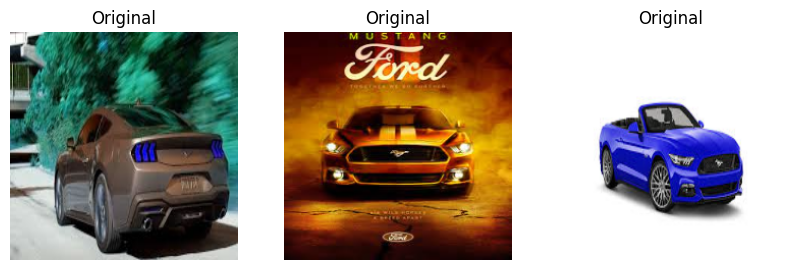

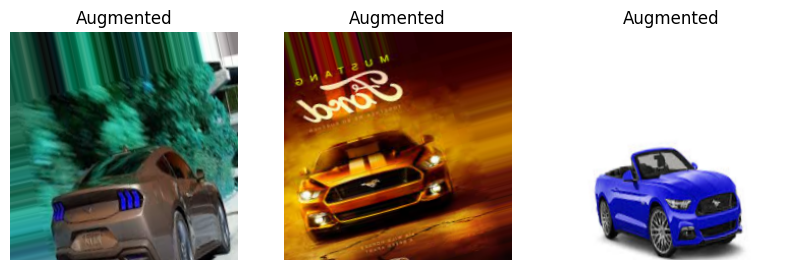

In [ ]:
# Function to display images
def show_images(images, titles):
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Load some original images for demonstration
original_images, _ = load_data(os.path.join(root_dir, 'train'), data_augmentation=False, target_size=(224, 224))

# Choose a few images for augmentation
sample_images = original_images[:3]

# Apply data augmentation
augmented_images = [augment_image(image) for image in sample_images]

# Display original and augmented images
show_images(sample_images, titles=['Original'] * len(sample_images))
show_images(augmented_images, titles=['Augmented'] * len(augmented_images))

#Visualize feature

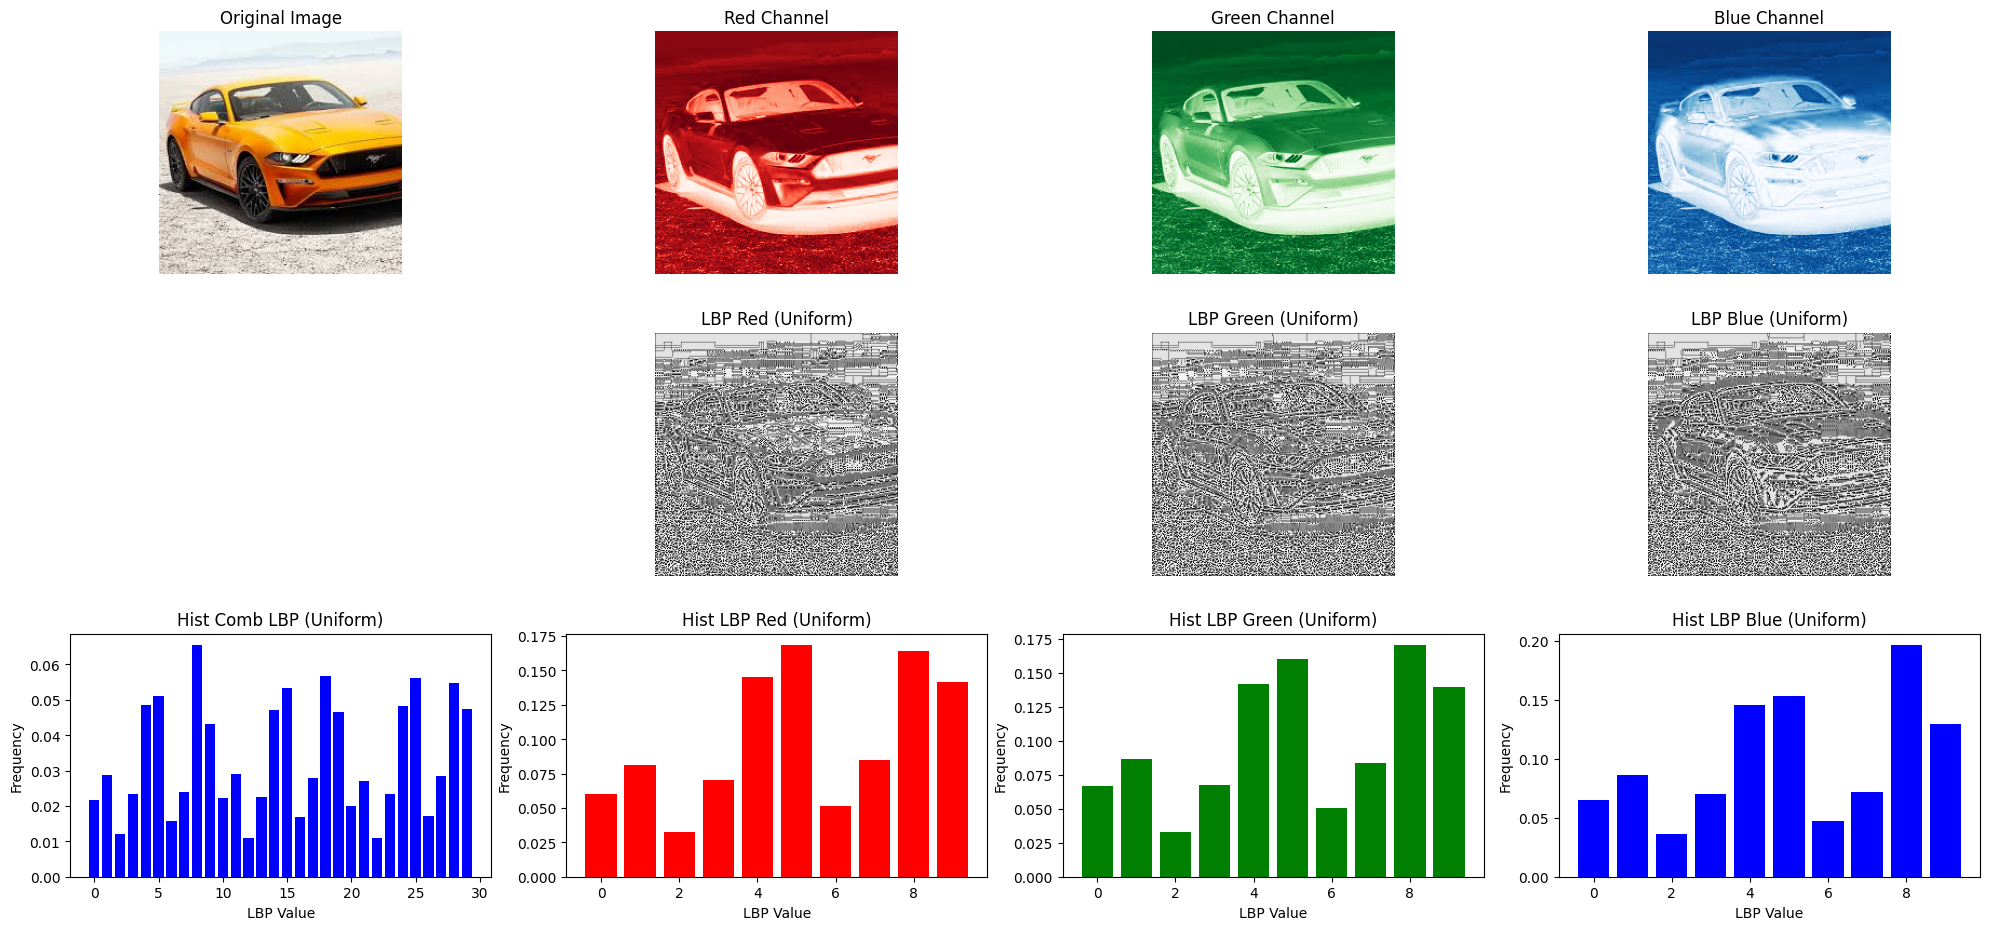

In [ ]:
def calculate_lbp(channel, n_points=8, radius=1, method='uniform'):
    return local_binary_pattern(channel, n_points, radius, method=method)

def calculate_combined_lbp(image, n_points=8, radius=1, method='uniform'):
    b, g, r = cv2.split(image)

    lbp_b = calculate_lbp(b, n_points, radius, method)
    lbp_g = calculate_lbp(g, n_points, radius, method)
    lbp_r = calculate_lbp(r, n_points, radius, method)

    bins = n_points + 2  # for uniform LBP
    hist_b, _ = np.histogram(lbp_b.flatten(), bins=np.arange(0, bins + 1), range=(0, bins))
    hist_g, _ = np.histogram(lbp_g.flatten(), bins=np.arange(0, bins + 1), range=(0, bins))
    hist_r, _ = np.histogram(lbp_r.flatten(), bins=np.arange(0, bins + 1), range=(0, bins))

    hist = np.concatenate([hist_b, hist_g, hist_r]).astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist, lbp_r, lbp_g, lbp_b

def plot_lbp_results(image, lbp_results, histograms):
    b, g, r = cv2.split(image)
    image_rgb = cv2.merge([r, g, b])

    hist_uniform, lbp_r_uniform, lbp_g_uniform, lbp_b_uniform = lbp_results
    hist_lbp_r_uniform, hist_lbp_g_uniform, hist_lbp_b_uniform = histograms

    plt.figure(figsize=(20, 15))

    plt.subplot(5, 4, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 4, 2)
    plt.imshow(r, cmap='Reds')
    plt.title('Red Channel')
    plt.axis('off')

    plt.subplot(5, 4, 3)
    plt.imshow(g, cmap='Greens')
    plt.title('Green Channel')
    plt.axis('off')

    plt.subplot(5, 4, 4)
    plt.imshow(b, cmap='Blues')
    plt.title('Blue Channel')
    plt.axis('off')

    plt.subplot(5, 4, 6)
    plt.imshow(lbp_r_uniform, cmap='gray')
    plt.title('LBP Red (Uniform)')
    plt.axis('off')

    plt.subplot(5, 4, 7)
    plt.imshow(lbp_g_uniform, cmap='gray')
    plt.title('LBP Green (Uniform)')
    plt.axis('off')

    plt.subplot(5, 4, 8)
    plt.imshow(lbp_b_uniform, cmap='gray')
    plt.title('LBP Blue (Uniform)')
    plt.axis('off')

    plt.subplot(5, 4, 9)
    plt.bar(np.arange(len(hist_uniform)), hist_uniform, color='blue')
    plt.title('Hist Comb LBP (Uniform)')
    plt.xlabel("LBP Value")
    plt.ylabel('Frequency')

    plt.subplot(5, 4, 10)
    plt.bar(np.arange(len(hist_lbp_r_uniform)), hist_lbp_r_uniform, color='red')
    plt.title('Hist LBP Red (Uniform)')
    plt.xlabel("LBP Value")
    plt.ylabel('Frequency')

    plt.subplot(5, 4, 11)
    plt.bar(np.arange(len(hist_lbp_g_uniform)), hist_lbp_g_uniform, color='green')
    plt.title('Hist LBP Green (Uniform)')
    plt.xlabel("LBP Value")
    plt.ylabel('Frequency')

    plt.subplot(5, 4, 12)
    plt.bar(np.arange(len(hist_lbp_b_uniform)), hist_lbp_b_uniform, color='blue')
    plt.title('Hist LBP Blue (Uniform)')
    plt.xlabel("LBP Value")
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def main():
    image_path = '/gdrive/MyDrive/Data/Data_Split/train/Car/1573.jpg'
    image = cv2.imread(image_path)

    # Calculate combined LBP and individual LBP for each color channel with uniform method
    hist_uniform, lbp_r_uniform, lbp_g_uniform, lbp_b_uniform = calculate_combined_lbp(image, 8, 1, method='uniform')

    # Calculate histograms for LBP images with uniform method
    hist_lbp_r_uniform, _  = np.histogram(lbp_r_uniform.flatten(), bins=np.arange(0, 11), range=(0, 10))
    hist_lbp_r_uniform = hist_lbp_r_uniform.astype("float")
    hist_lbp_r_uniform /= (hist_lbp_r_uniform.sum() + 1e-7)

    hist_lbp_g_uniform, _ = np.histogram(lbp_g_uniform.flatten(), bins=np.arange(0, 11), range=(0, 10))
    hist_lbp_g_uniform = hist_lbp_g_uniform.astype("float")
    hist_lbp_g_uniform /= (hist_lbp_g_uniform.sum() + 1e-7)

    hist_lbp_b_uniform, _ = np.histogram(lbp_b_uniform.flatten(), bins=np.arange(0, 11), range=(0, 10))
    hist_lbp_b_uniform = hist_lbp_b_uniform.astype("float")
    hist_lbp_b_uniform /= (hist_lbp_b_uniform.sum() + 1e-7)

    plot_lbp_results(image,
                     (hist_uniform, lbp_r_uniform, lbp_g_uniform, lbp_b_uniform),
                     (hist_lbp_r_uniform, hist_lbp_g_uniform, hist_lbp_b_uniform))

if __name__ == "__main__":
    main()

# Extract features

In [ ]:
def extract_features(image, method='uniform', n_points=8, radius=1):
    image = cv2.resize(image, (224, 224))
    b, g, r = cv2.split(image)

    # Calculate LBP for each channel
    lbp_b = local_binary_pattern(b, n_points, radius, method=method)
    lbp_g = local_binary_pattern(g, n_points, radius, method=method)
    lbp_r = local_binary_pattern(r, n_points, radius, method=method)

    # Create histogram for each color channel
    hist_b, _ = np.histogram(lbp_b.flatten(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist_g, _ = np.histogram(lbp_g.flatten(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist_r, _ = np.histogram(lbp_r.flatten(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

    # Concatenate histograms
    hist = np.concatenate([hist_b, hist_g, hist_r])
    hist = hist.astype("float")

    # Normalize the histogram
    hist /= (hist.sum() + 1e-7)

    return hist

In [ ]:
# Extract features
X_train_features = np.array([extract_features(image) for image in X_train])
X_val_features = np.array([extract_features(image) for image in X_val])
X_test_features = np.array([extract_features(image) for image in X_test])

print(X_train_features.shape)
print(X_val_features.shape)
print(X_test_features.shape)

(2935, 30)
(488, 30)
(491, 30)


#Train model

In [ ]:
# Train SVM model without tuning
svm_model_default = SVC()
svm_model_default.fit(X_train_features, y_train)

# Predictions on test set
predictions = svm_model_default.predict(X_test_features)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[224  21]
 [ 23 223]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       245
           1       0.91      0.91      0.91       246

    accuracy                           0.91       491
   macro avg       0.91      0.91      0.91       491
weighted avg       0.91      0.91      0.91       491



#Find best Hyperparameter

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ["rbf", "linear", "poly", "sigmoid"],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
}

# create GridSearchCV object
grid = GridSearchCV(SVC(), param_grid, verbose=3)

# fitting the model for grid search
grid.fit(X_train_features, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.503 total time=   0.5s
[CV 2/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.503 total time=   0.5s
[CV 3/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.503 total time=   0.5s
[CV 4/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.501 total time=   0.5s
[CV 5/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.501 total time=   0.5s
[CV 1/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.503 total time=   0.3s
[CV 2/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.503 total time=   0.3s
[CV 3/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.503 total time=   0.3s
[CV 4/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.501 total time=   0.4s
[CV 5/5] END C=0.01, gamma=0.0001, kernel=linear;, score=0.501 total time=   0.3s
[CV 1/5] END .C=0.01, gamma=0.0001, kernel=poly;, score=0.503 total time=   0.3s
[CV 2/5] END .C=0.01, gamma=0.0001, kerne

#Final model

In [ ]:
svm_model = grid.best_estimator_
svm_model.fit(X_train_features, y_train)

SVC(C=100, gamma=1)

#Result

Train Set
Confusion Matrix:
 [[1382   80]
 [ 128 1345]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      1462
           1       0.94      0.91      0.93      1473

    accuracy                           0.93      2935
   macro avg       0.93      0.93      0.93      2935
weighted avg       0.93      0.93      0.93      2935


Accuracy: 0.9291311754684838


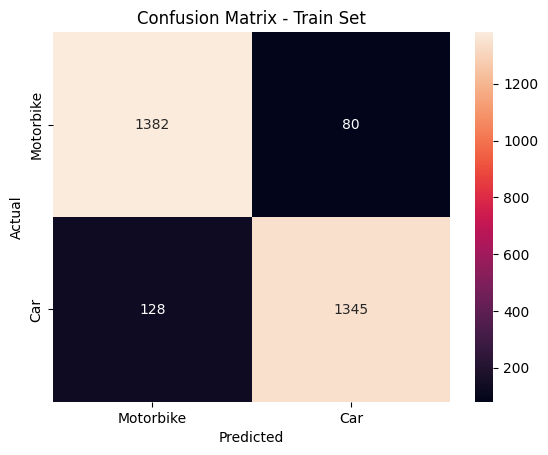

In [ ]:
from sklearn import metrics
import seaborn as sns
# Predictions on train set
y_pred_train = svm_model.predict(X_train_features)

# Evaluate the model on train set
print("Train Set")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
print("\nAccuracy:", accuracy_score(y_train, y_pred_train))

# Confusion matrix
cmat = metrics.confusion_matrix(y_train, y_pred_train)
sns.heatmap(cmat, annot=True, fmt='d', xticklabels=['Motorbike', 'Car'], yticklabels=['Motorbike', 'Car'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Train Set')
plt.show()

Validation Set
Confusion Matrix:
 [[231  12]
 [ 13 232]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       243
           1       0.95      0.95      0.95       245

    accuracy                           0.95       488
   macro avg       0.95      0.95      0.95       488
weighted avg       0.95      0.95      0.95       488


Accuracy: 0.9487704918032787


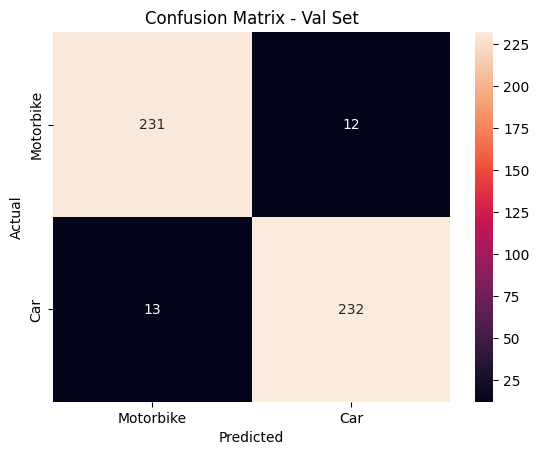

In [ ]:
# Predictions on validation set
y_pred_val = svm_model.predict(X_val_features)

# Evaluate the model on validation set
print("Validation Set")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))
print("\nAccuracy:", accuracy_score(y_val, y_pred_val))

# Confusion matrix
cmat = metrics.confusion_matrix(y_val, y_pred_val)
sns.heatmap(cmat, annot=True, fmt='d', xticklabels=['Motorbike', 'Car'], yticklabels=['Motorbike', 'Car'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Val Set')
plt.show()

Test Set
Confusion Matrix:
 [[223  22]
 [ 13 233]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       245
           1       0.91      0.95      0.93       246

    accuracy                           0.93       491
   macro avg       0.93      0.93      0.93       491
weighted avg       0.93      0.93      0.93       491


Accuracy: 0.9287169042769857


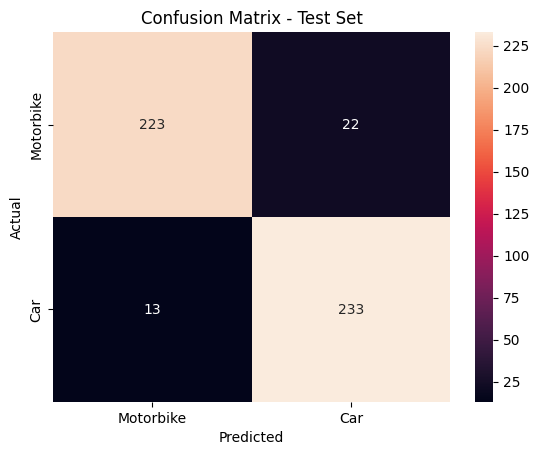

In [ ]:
# Predictions on test set
y_pred_test = svm_model.predict(X_test_features)

# Evaluate the model on test set
print("Test Set")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))
print("\nAccuracy:", accuracy_score(y_test, y_pred_test))

# Confusion matrix visualization for test set
cmat = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cmat, annot=True, fmt='d', xticklabels=['Motorbike', 'Car'], yticklabels=['Motorbike', 'Car'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

#Demo

44
Wrong Test Cases:
Predicted: Motorbike
Actual: Car


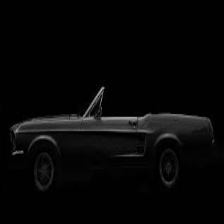

Predicted: Motorbike
Actual: Car


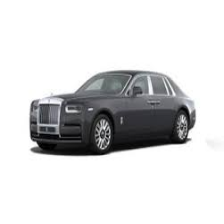

Predicted: Motorbike
Actual: Car


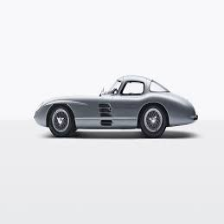

Predicted: Motorbike
Actual: Car


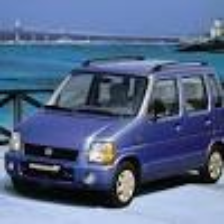

Predicted: Motorbike
Actual: Car


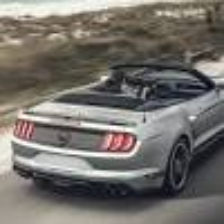

Predicted: Car
Actual: Motorbike


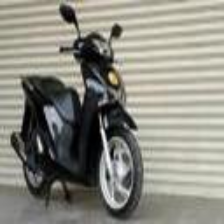

Predicted: Car
Actual: Motorbike


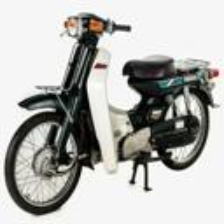

Predicted: Car
Actual: Motorbike


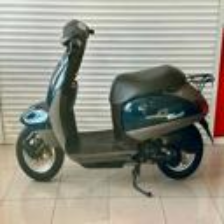

Predicted: Car
Actual: Motorbike


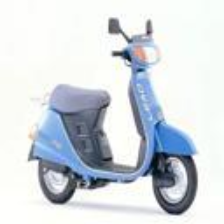

Predicted: Car
Actual: Motorbike


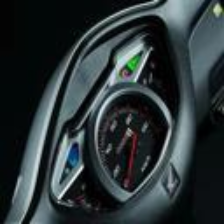

Correct Test Cases:
Predicted: Car
Actual: Car


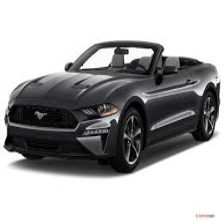

Predicted: Car
Actual: Car


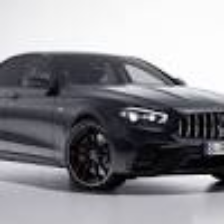

Predicted: Car
Actual: Car


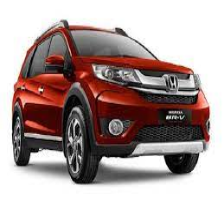

Predicted: Car
Actual: Car


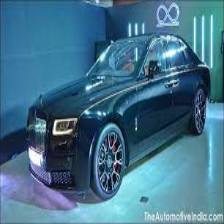

Predicted: Car
Actual: Car


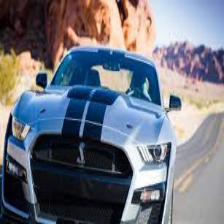

Predicted: Motorbike
Actual: Motorbike


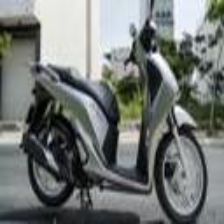

Predicted: Motorbike
Actual: Motorbike


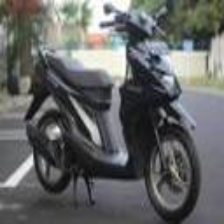

Predicted: Motorbike
Actual: Motorbike


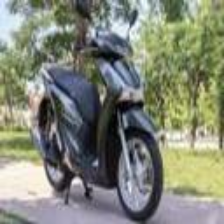

Predicted: Motorbike
Actual: Motorbike


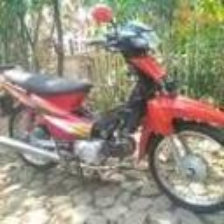

Predicted: Motorbike
Actual: Motorbike


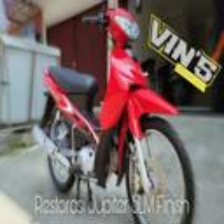

In [ ]:
from google.colab.patches import cv2_imshow

num_cases = 5
# Find wrong and correct indices
wrong_indices = [i for i in range(len(y_test)) if predictions[i] != y_test[i]]
print(len(wrong_indices))
correct_indices = [i for i in range(len(y_test)) if predictions[i] == y_test[i]]

# Function to get cases by label
def get_cases_by_label(indices, label, num_cases, y_test):
    return [i for i in indices if y_test[i] == label][:num_cases]

# Get wrong and correct cases by label
wrong_car_indices = get_cases_by_label(wrong_indices, 1, num_cases, y_test)
wrong_motorbike_indices = get_cases_by_label(wrong_indices, 0, num_cases, y_test)
correct_car_indices = get_cases_by_label(correct_indices, 1, num_cases, y_test)
correct_motorbike_indices = get_cases_by_label(correct_indices, 0, num_cases, y_test)

# Display wrong test cases
print("Wrong Test Cases:")
for i in wrong_car_indices + wrong_motorbike_indices:
    print("Predicted:", "Car" if predictions[i] == 1 else "Motorbike")
    print("Actual:", "Car" if y_test[i] == 1 else "Motorbike")
    # Display original image
    image_path = X_test[i]

    cv2_imshow(image_path)

# Display correct test cases
print("Correct Test Cases:")
for i in correct_car_indices + correct_motorbike_indices:
    print("Predicted:", "Car" if predictions[i] == 1 else "Motorbike")
    print("Actual:", "Car" if y_test[i] == 1 else "Motorbike")
    # Display original image
    image_path = X_test[i]

    cv2_imshow(image_path)

Predicted: Car
Actual: Car


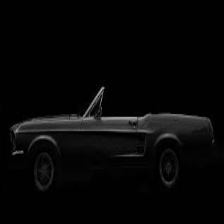

Predicted: Car
Actual: Car


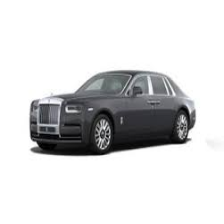

Predicted: Car
Actual: Car


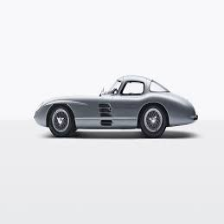

Predicted: Car
Actual: Car


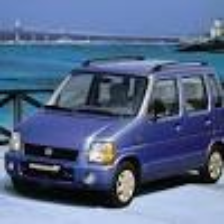

Predicted: Car
Actual: Car


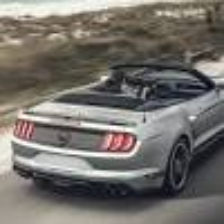

Predicted: Car
Actual: Motorbike


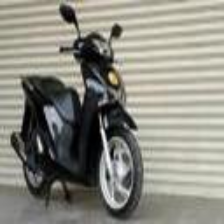

Predicted: Car
Actual: Motorbike


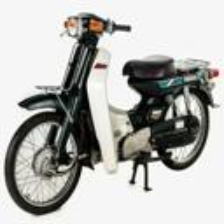

Predicted: Car
Actual: Motorbike


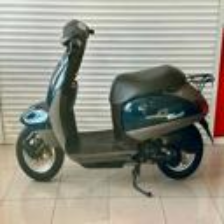

Predicted: Car
Actual: Motorbike


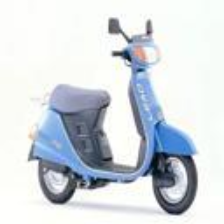

Predicted: Car
Actual: Motorbike


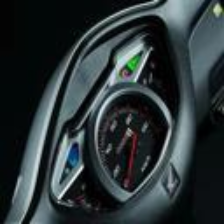

Predicted: Car
Actual: Car


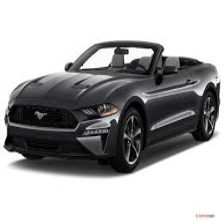

Predicted: Car
Actual: Car


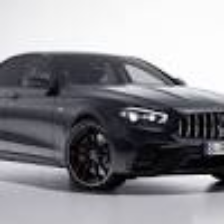

Predicted: Car
Actual: Car


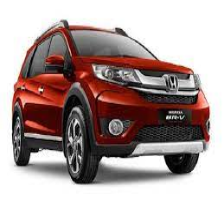

Predicted: Car
Actual: Car


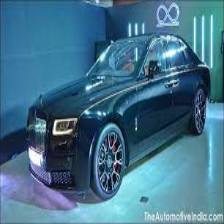

Predicted: Car
Actual: Car


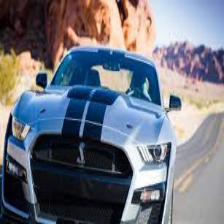

Predicted: Motorbike
Actual: Motorbike


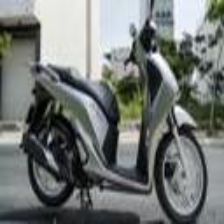

Predicted: Motorbike
Actual: Motorbike


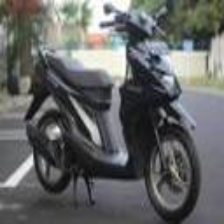

Predicted: Motorbike
Actual: Motorbike


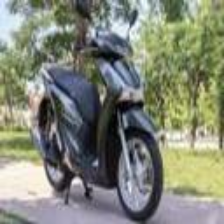

Predicted: Motorbike
Actual: Motorbike


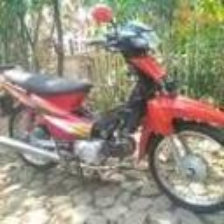

Predicted: Motorbike
Actual: Motorbike


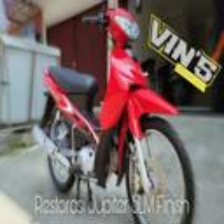

In [ ]:
for i in wrong_car_indices + wrong_motorbike_indices:
    print("Predicted:", "Car" if y_pred_test[i] == 1 else "Motorbike")
    print("Actual:", "Car" if y_test[i] == 1 else "Motorbike")
    # Display original image
    image_path = X_test[i]
    cv2_imshow(image_path)

for i in correct_car_indices + correct_motorbike_indices:
    print("Predicted:", "Car" if y_pred_test[i] == 1 else "Motorbike")
    print("Actual:", "Car" if y_test[i] == 1 else "Motorbike")
    # Display original image
    image_path = X_test[i]
    cv2_imshow(image_path)